# Análisis de Información no Estructurada
# Práctica final: Predictor de precios de casas en base a su descripción

## - Yago Carbó
## - Juan Sevilla
## - Javier Concejo

Nuestro trabajo consiste en un predictor de precios de viviendas en función a la descripción que el vendedor proporciona. Para ello, hemos extraido dos conjuntos de datos. EL primero de ellos contiene viviendas pertenecientes al barrio de Salamanca (Madrid). Puesto que este no era representativo, ya que es uno de los barrios mas caros de Madrid y por lo tanto las viviendas serán parecidas, obtenemos el segundo conjunto de datos de viviendes pertenecientes a los barrios de Pacífico y Vallecas. 

En cuanto a las funciones de los miembros del grupo, estas son las siguientes:
- Yago Carbó: Extracción de datos mediente web scrapping
- Juan Sevilla: Preprocesamiento de los datos
- Javier Concejo: Definición de los modelos

# Barrio Salamanca

In [1]:
import pandas as pd
import warnings
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import os

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

nlp= spacy.load('es_core_news_lg')
random_state=1234

In [2]:
# read_csv is the function that reads csvs, it returns a Pandas dataframe
WD_Javier = "C:/Users/javoc/OneDrive/Escritorio/MASTER/AnalisisDeInformacionNoEstructurada/Practica final"
WD_Juan = "/Users/juan/Documents/Juan's MacBook Pro/CUNEF/Quinto/Informacion no Estructurada/Practica Final"
WD_Yago = "???"

##### Change Working Directory ####
os.chdir(WD_Juan) #################
###################################

df=pd.read_excel("salamanca.xlsx")
df.head(5)

,title,price,info_features,comment,details
0,Piso en venta en calle de Don Ramón de la Cruz...,398.000 €,109 m²\n3 hab.\nPlanta 4ª interior con ascensor,¡Fantástica inversión! Descuento de aproximada...,Características básicas\n109 m² construidos\n3...
1,Dúplex en venta en Recoletos\nBarrio de Salama...,745.000 €,115 m²\n2 hab.\nPlanta 1ª exterior con ascensor,Excelente propiedad en Recoletos\nEngel & Völk...,Características básicas\n115 m² construidos\n2...
2,Piso en venta en Castellana\nBarrio de Salaman...,850.000 €,161 m²\n3 hab.\nPlanta 1ª interior con ascensor,Propiedad en la mejor zona de Castellana\nEnge...,"Características básicas\n161 m² construidos, 1..."
3,"Piso en venta en General Pardiñas\nGoya, Madri...",850.000 €,112 m²\n2 hab.\nPlanta 5ª exterior con ascensor,"Precioso piso exterior, muy luminoso, en barri...","Características básicas\n112 m² construidos, 9..."
4,"Piso en venta en calle de Lagasca\nRecoletos, ...",890.000 €,134 m²\n2 hab.\nSemi-sótano exterior con ascensor,Grupo Marsapi vende en EXCLUSIVA este increíbl...,Características básicas\n134 m² construidos\n2...


### *TFIDF y wordcloud Barrio Salamanca*

In [3]:
warnings.filterwarnings("ignore")
def tfidf(datos):
    """Esta función devuelve un data frame con los tokens ordenados 
    en base a su importancia absoluta según la TFIDF"""
    TFIDF_vectorizer = TfidfVectorizer()
    TFIDF_array=TFIDF_vectorizer.fit_transform(datos).toarray()
    vocab_TFIDF = TFIDF_vectorizer.get_feature_names()
    TFIDF=pd.DataFrame(TFIDF_array, columns=vocab_TFIDF)
    TFIDF_bueno=pd.DataFrame(TFIDF.sum(axis=0),columns=['Importancia'])
    return(TFIDF_bueno.sort_values(by=['Importancia'], ascending=False)).head(40)

stopwords = nlp.Defaults.stop_words
datos_stopwords=list(df["comment"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)])))

tfidf_stopwords=tfidf(datos_stopwords)
tfidf_stopwords=tfidf_stopwords.reset_index()
tfidf_stopwords.head()

,index,Importancia
0,zona,8.382756
1,la,6.995081
2,salamanca,6.690147
3,madrid,6.630867
4,vivienda,6.311646


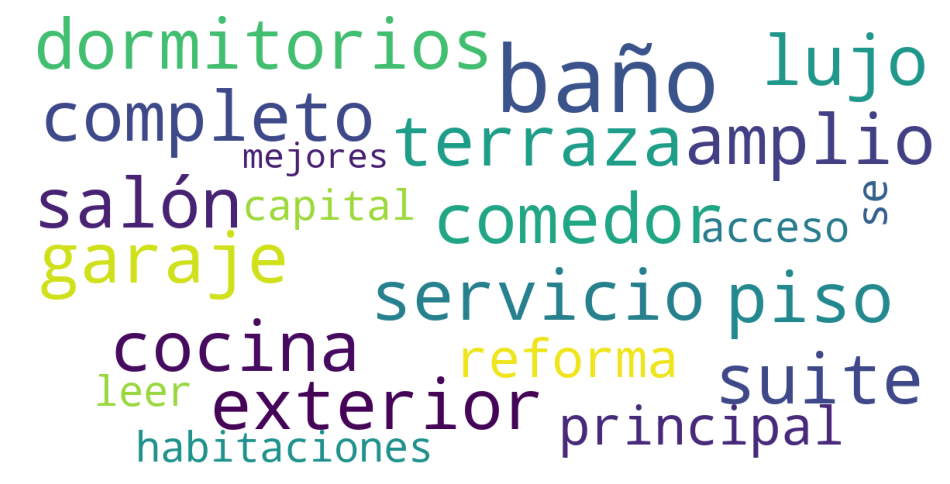

In [4]:
comentarios = tfidf_stopwords[tfidf_stopwords["index"].str.contains("salamanca|madrid|barrio|zona|vivienda|la|calle|el|en|calles|clientes|propiedad|zonas|edificio|castellana|recoletos|ciudad|finca|portal") == False]
comentarios = comentarios.reset_index()
comentarios = comentarios.drop(['level_0'], axis=1)

def show_wordcloud(data, title = None):
    """Grafica un Wordcloud con el string de entrada"""
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(' '.join(comentarios['index']))

Obtenemos los tokens más frecuentes en base a nuestra función TFIDF de tal manera que así podemos analizar que términos se repiten más en las descripciones de la vivienda. Es importante destacar que hemos excluido, para posteriormente hacer un wordcloud, aquellas palabras que no eran representativas. Estas son palabras que se suelen repetir en casi todos los casos o que, por otro lado, nos tienen relevancia a la hora de determinar el precio puesto que no aportan información. Un ejemplo de esta última exclusión es la palabra vivienda, ya que deducimos que todos nuestros datos son viviendas. Un vez tenemos este filtro realizado, obtenemos un wordcloud que nos permite ver visualmente que palabras son más frecuentes en las descripcciones.

### *Predicción de precios Barrio Salamanca*

In [5]:
def symbol_remover(col, symbollist, num = True):
    """
    Esta funcion sirve para formatear columnas numericas que incluyen simbolos
    
    Input: 
    col : columna a formatear
    symbollist : lista de simbolos a eliminar
    num : si la variable final se quiere convertir a numerica
    
    Output: columna con valores libre de simbolos y convertida en numerica si procede
    """
    
    for s in symbollist:
        col = col.str.replace(s, '')
    if num == True: 
        col = col.astype(float)
    
    return col

In [6]:
predictor=df.copy()

predictor['price'] = symbol_remover(predictor['price'], [".","€"])

predictor['quantile'] = pd.qcut(predictor['price'], 5, labels=False)
predictor['quantile'] = predictor['quantile'].replace([0,1,2,3,4], [0, 1, 1, 1, 2])

In [7]:
texto = predictor['comment']
label = predictor['quantile']

vectorizer = TfidfVectorizer()
texto_tfidf = vectorizer.fit_transform(texto)

Creamos una columna que nos clasifica el precio de la vivienda en una variable discreta que toma 3 valores (barato, medio y caro). Hemos tenido que crear esta columna para poder generar nuestro modelo de clasificación. El método que hemos seguido para su creación ha sido mediante cuantiles. EL resultado final es que el primer 20% de las viviendas, ordenadas de menor a mayor precio, obtienen la clasificación de baratas, el siguiente 60% de medio, y el último 20% de caro.

### *Modelos de clasificación Barrio Salamanca*

In [8]:
def run_models(texto_tfidf, label, modellist):
    """ 
        Este funcion entrena cada modelo definido en lista input, predice las clases para el conjunto test y
        calcula el accuracy de entrenamiento y test, asi como la matriz de confusion par cada modelo.
        
        Input: 
            modellist: lista de strings con los modelos a entrenar
            
        Output:
            matriz de confusion, accuacy de entrenaiento, test y fiabilidad para cada modelo entrenado
    """
    plt.rcParams["figure.figsize"] = (20,3)
    
    texto_train, texto_test, label_train, label_test = train_test_split(texto_tfidf, label, train_size = 0.8, random_state=random_state, stratify=label)
    
    for name in modellist:
        if name == "Bayesiano Ingenuo":
            model = MultinomialNB()
        if name == "SVC":
            model = SVC(kernel='linear')
        if name == "XGBoost":
            model = XGBClassifier(n_jobs = -1, random_state = random_state)


        model.fit(texto_train, label_train)
        categs_pred = model.predict(texto_test)
        acc_train = model.score(texto_train, label_train)
        acc_test = model.score(texto_test, label_test)
        ConfusionMatrixDisplay.from_predictions(label_test, categs_pred, display_labels = ["Barato","Medio", "Caro"]);
        

        # Confusion Matrix
        print('Para el modelo','\033[1m' + str(name) + '\033[0m',"matriz de confusion es:")
        plt.show()
        print("Con un accuracy de train de:", round(acc_train*100,2),"%")
        print("Con un accuracy de test de:", round(acc_test*100,2),"%")
        print("Con una fiabilidad de:", round(acc_test/acc_train*100,2),"%", "\n")

Para el modelo Bayesiano Ingenuo matriz de confusion es:


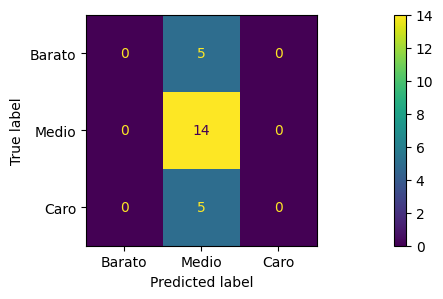

Con un accuracy de train de: 60.42 %
Con un accuracy de test de: 58.33 %
Con una fiabilidad de: 96.55 % 

Para el modelo SVC matriz de confusion es:


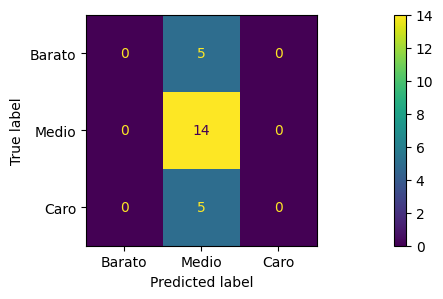

Con un accuracy de train de: 77.08 %
Con un accuracy de test de: 58.33 %
Con una fiabilidad de: 75.68 % 

Para el modelo XGBoost matriz de confusion es:


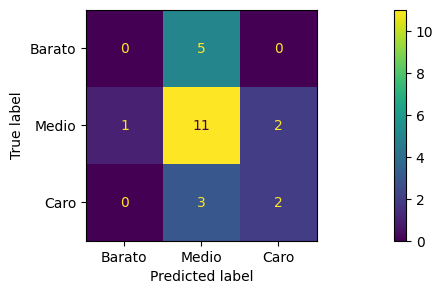

Con un accuracy de train de: 100.0 %
Con un accuracy de test de: 54.17 %
Con una fiabilidad de: 54.17 % 



In [9]:
modellist = ["Bayesiano Ingenuo", "SVC", "XGBoost"]
run_models(texto_tfidf, label, modellist)

Realizamos 3 modelos de clasificación (Bayesiano Ingenuo, SVM y XGBoost). Como se puede observar, los resultados obtenidos no son buenos ya que obtenemos que casi todas las predicciones indican que la vivienda tiene un precio medio para esta zona. Es decir, ante la duda, el modelo clasifica como precio media. Esto también se debe a que la muestra está muy desbalanceada. Por ello, decidimos volver a realizar esto con un conjunto de viviendas mas extenso y con mayor variabilidad en el precio.

# Pacífico y Vallecas

In [10]:
df2=pd.read_excel("Data_pacifico_vallecas_info_no_estruct.xlsx")
df2.head(5)

,title,price,info_features,comment,details
0,Piso en venta en Palomeras Bajas\nPuente de Va...,61.000 €,86 m²\n3 hab.\nPlanta -1 exterior sin ascensor,"VENTA DE LA NUDA PROPIEDAD, SOLO PARA INVERSOR...","Características básicas\n86 m² construidos, 81..."
1,Piso en venta en calle de Josué Lillo s/n\nSan...,112.000 €,86 m²\n3 hab.\nPlanta 1ª sin ascensor,Piso ocupado por persona sin justo título. Est...,"Características básicas\n86 m² construidos, 75..."
2,"Piso en venta en avenida Palomeras, 9\nPalomer...",112.100 €,110 m²\n2 hab.\nPlanta 1ª exterior sin ascensor,"Edificio situado en la ciudad de Madrid, provi...",Características básicas\n110 m² construidos\n2...
3,Piso en venta en calle de Peña Redonda\nPalome...,119.000 €,91 m²\n3 hab.\nBajo exterior sin ascensor,SERVICHECK INMOBILIARIA VENDE PISO DE 3 HABITA...,"Características básicas\n91 m² construidos, 80..."
4,Piso en venta en avenida de San Diego\nSan Die...,120.000 €,87 m²\n3 hab.\nPlanta 1ª exterior sin ascensor,"Vivienda situada en 1ªplanta, contamos con 87m...","Características básicas\n87 m² construidos, 71..."


### *TFIDF y wordcloud Pacífico y Vallecas*

In [11]:
datos_stopwords2=list(df2["comment"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)])))

tfidf_stopwords2=tfidf(datos_stopwords2)
tfidf_stopwords2=tfidf_stopwords2.reset_index()
tfidf_stopwords2.head()

,index,Importancia
0,vivienda,11.971317
1,piso,10.197562
2,zona,9.105060
3,cocina,8.278523
4,la,8.221790


A diferencia del conjunto de datos anterior, este está compuesto por viviendas de dos barrios de Madrid (Pacífico y Vallecas)

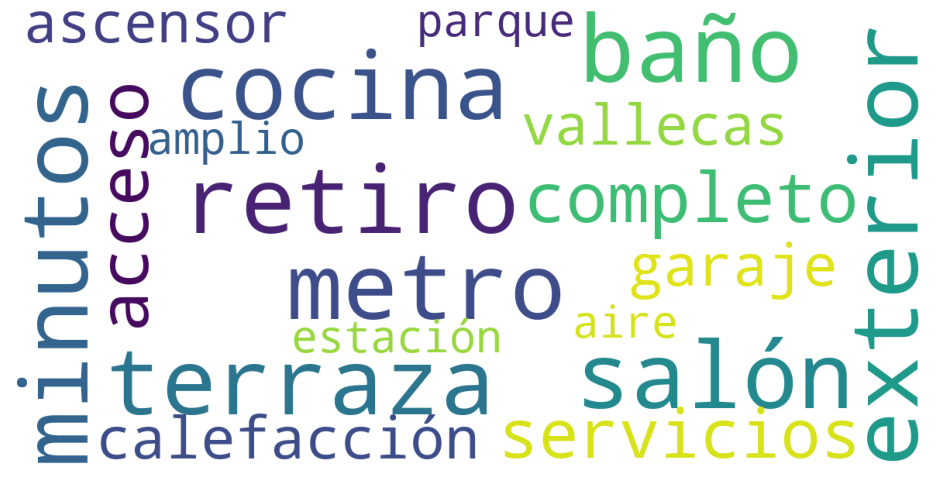

In [12]:
comentarios2 = tfidf_stopwords2[tfidf_stopwords2["index"].str.contains("vivienda|piso|zona|la|el|madrid|dormitorios|habitaciones|baños|no|m2|calle|acondicionado|edificio|dispone|comedor|metros|armarios|plaza|viviendas") == False]
comentarios2 = comentarios2.reset_index()
comentarios2 = comentarios2.drop(['level_0'], axis=1)

show_wordcloud(' '.join(comentarios2['index']))

Al igual que con el conjunto de viviendas anterior, obtenemos el wordcloud para este quitando las palabras que son menos representativas. En este caso hemos dejado la zona ya que son viviendas en dos barrios distintos.

### *Predicción de precios Pacífico y Vallecas*

In [13]:
def feature_create(df, identifier, criteria = "start", value = "bool"):
    """
    Esta funcion crea una columna con la informacion deseada de la columna info_features
    
    Imput:
    df: dataframe con la columna info_features
    identifier: en que string se basa para encontrar el dato
    criteria: si el string lo busca al principio o al final del elemento
    value: "bool"/"value" si se desea que el la funcion devuelva el valor encontrado 
            o un booleano si se encuentra el valor buscado
            Por ejemplo en m2 busca el valor, mientras que para ascensor Bool de si hay en el piso.
    
    Output: Columna con la informacion deseada de la columna info_features
    """
    blank = []
    for i in range(len(df)):
        if not len(df["info_features"][i]) == 0:
                if (criteria == "start" and df["info_features"][i][0].startswith(identifier)) or \
                (criteria == "end" and df["info_features"][i][0].endswith(identifier)):
                    if value == "bool":
                        blank.append(True)
                    if value == "value":
                        blank.append(df["info_features"][i][0])
                    del df["info_features"][i][0]
                else: blank.append(False)
        else: blank.append(False)
    

    return blank

In [14]:
df2["info_features"] = df2["info_features"].str.split('\n')
df2["details"] = df2["details"].str.split('\n')
df2["price"] = symbol_remover(df2["price"], [".","€"])

In [15]:
for i in range(len(df2)):
    if not len(df2["info_features"][i]) == 0:
            if df2["info_features"][i][0].startswith(("Obra","Urge")):
                del df2["info_features"][i][0]

In [16]:
df2["m2"] = feature_create(df = df2, identifier = "m²", criteria = "end", value = "value")
df2["m2"] = symbol_remover(df2["m2"], [" m²"])

In [17]:
df2["hab"] = feature_create(df = df2, identifier = "hab.", criteria = "end", value = "value")
df2["hab"] = symbol_remover(df2["hab"], [" hab."])

In [18]:
procesado = df2.copy()
procesado['Precio/m2']=(procesado['price']/procesado['m2']).round(2)
procesado.head(5)

,title,price,info_features,comment,details,m2,hab,Precio/m2
0,Piso en venta en Palomeras Bajas\nPuente de Va...,61000.0,[Planta -1 exterior sin ascensor],"VENTA DE LA NUDA PROPIEDAD, SOLO PARA INVERSOR...","[Características básicas, 86 m² construidos, 8...",86.0,3.0,709.30
1,Piso en venta en calle de Josué Lillo s/n\nSan...,112000.0,[Planta 1ª sin ascensor],Piso ocupado por persona sin justo título. Est...,"[Características básicas, 86 m² construidos, 7...",86.0,3.0,1302.33
2,"Piso en venta en avenida Palomeras, 9\nPalomer...",112100.0,[Planta 1ª exterior sin ascensor],"Edificio situado en la ciudad de Madrid, provi...","[Características básicas, 110 m² construidos, ...",110.0,2.0,1019.09
3,Piso en venta en calle de Peña Redonda\nPalome...,119000.0,[Bajo exterior sin ascensor],SERVICHECK INMOBILIARIA VENDE PISO DE 3 HABITA...,"[Características básicas, 91 m² construidos, 8...",91.0,3.0,1307.69
4,Piso en venta en avenida de San Diego\nSan Die...,120000.0,[Planta 1ª exterior sin ascensor],"Vivienda situada en 1ªplanta, contamos con 87m...","[Características básicas, 87 m² construidos, 7...",87.0,3.0,1379.31


In [19]:
predictor2=procesado.copy()

def flag(df):
    if (df['Precio/m2'] < 3000): return 0
    elif(df['Precio/m2'] >= 3000 and df['Precio/m2'] < 5000): return 1
    else: return 2
predictor2['quantileXGB'] = predictor2.apply(flag, axis=1)

In [20]:
texto2 = predictor2['comment']
label2 = predictor2['quantileXGB']

texto_tfidf2 = vectorizer.fit_transform(texto2)

Para etse conjunto de datos hemos tenido que crear 3 columnas nuevas en base a la variable info_features la cual nos aportaba información de la vivienda. Estas nuevas variables son los metros cuadrados, el número de habitaciones y el precio por metro cuadrado. El motivo por el cual hemos realizado esto es porque ahora tenemos viviendas de dos barrios distintos y, por lo tanto, necesitamos una variable del precio estandarizada ya que una casa grande en un barrio barato puede llegar a ser mas cara que una vivienda pequeña en un barrio caro. Para evitar el sesgo del tamaño de la casa, tomamos el precio por metro cuadrado sobre el cual generaremos la variable de clasificación. Esta variable de clasificación tomará ell valor de 0 si el precio por metro cuadrado es de menos de 3000, 1 si está entre 3000 y 5000, y 2 si es más de 5000. Hemos establecido estos límites ya que es donde hemos observado un mayor salto en el precio de una vivienda a otra.

### *Modelos de clasificación Pacífico y Vallecas*

Para el modelo Bayesiano Ingenuo matriz de confusion es:


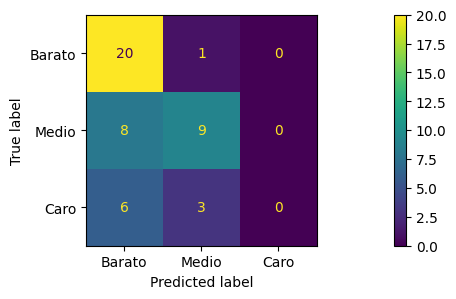

Con un accuracy de train de: 79.26 %
Con un accuracy de test de: 61.7 %
Con una fiabilidad de: 77.85 % 

Para el modelo SVC matriz de confusion es:


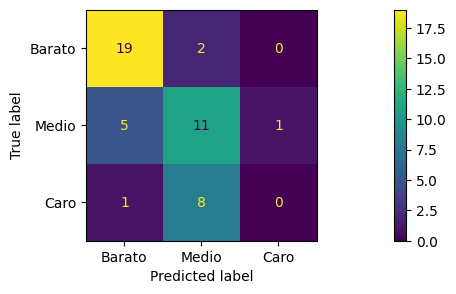

Con un accuracy de train de: 96.81 %
Con un accuracy de test de: 63.83 %
Con una fiabilidad de: 65.93 % 

Para el modelo XGBoost matriz de confusion es:


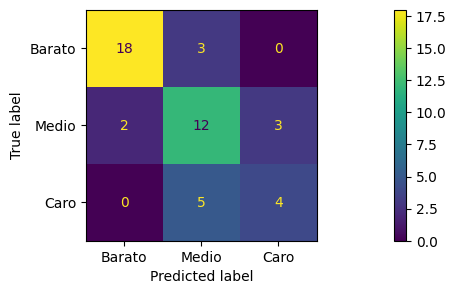

Con un accuracy de train de: 98.94 %
Con un accuracy de test de: 72.34 %
Con una fiabilidad de: 73.12 % 



In [21]:
run_models(texto_tfidf2, label2, modellist)

Como se puede observar, los resultados obtenidos en estos modelos de clasificación son mucho mejores que para el barrio de salamanca.

## Mejoras al trabajo despues de feedback en clase

Como comentamos tras la presentación, para verificar nuestra segmentacion entre viviendas baratas, medias y caras para los datos de Pacífico/Vallecas vamos a realizar sobre la variable de precio/m2 un clustering Kmeans con tres clusters como output.

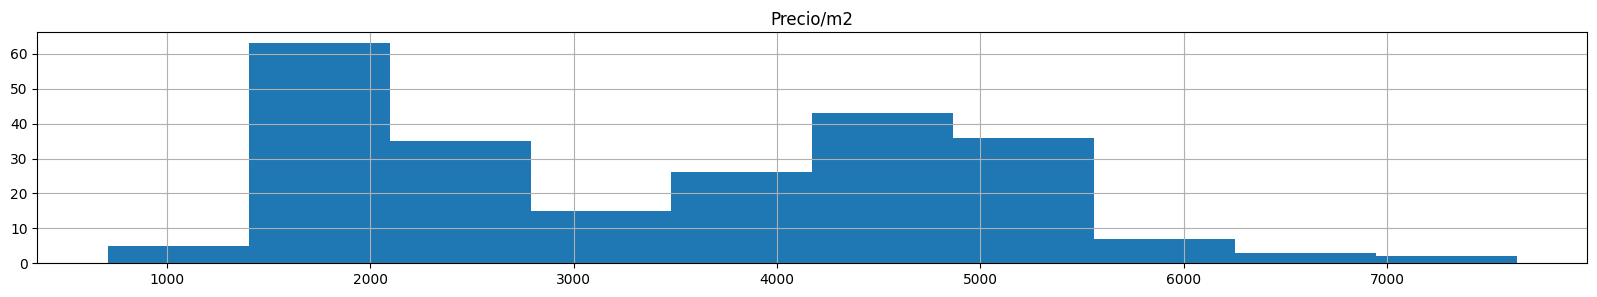

In [22]:
predictor2.hist(column="Precio/m2");

Vemos la distribucion de precio/m2 de nuestros datos. Estos cambios de frecuencia fue en lo que nos basamos para segmentar las casas entre baratas, medias y caras. Con unas fronteras de 3000 y 5000 euros/m2 para dividir las tres clases, dando lugar al siguiente grafico:

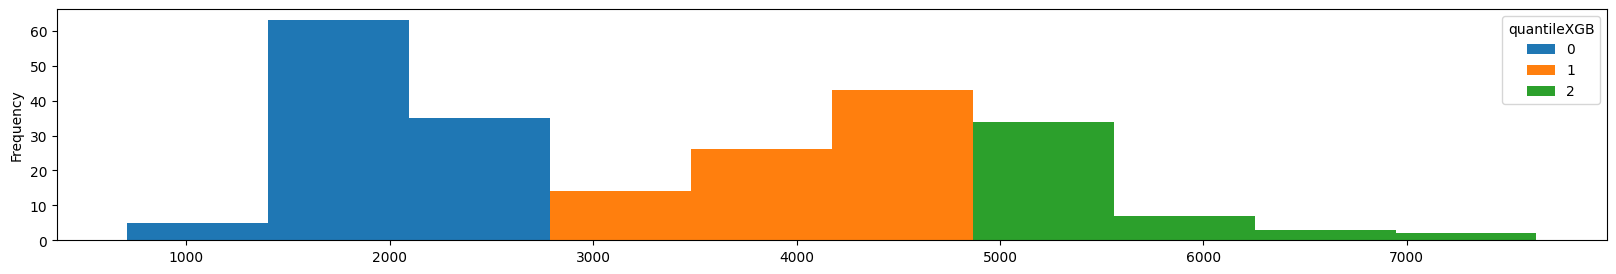

In [23]:
predictor2.pivot(columns='quantileXGB', values="Precio/m2").plot.hist();

A continución, creamos una varibale con los clusters asignados por el Kmeans y volvemos a graficar el mismo histograma de distribucion de precio/m2 pero coloreando por cluster:

In [24]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(predictor2[["Precio/m2"]])
predictor2["cluster"] = kmeans.labels_

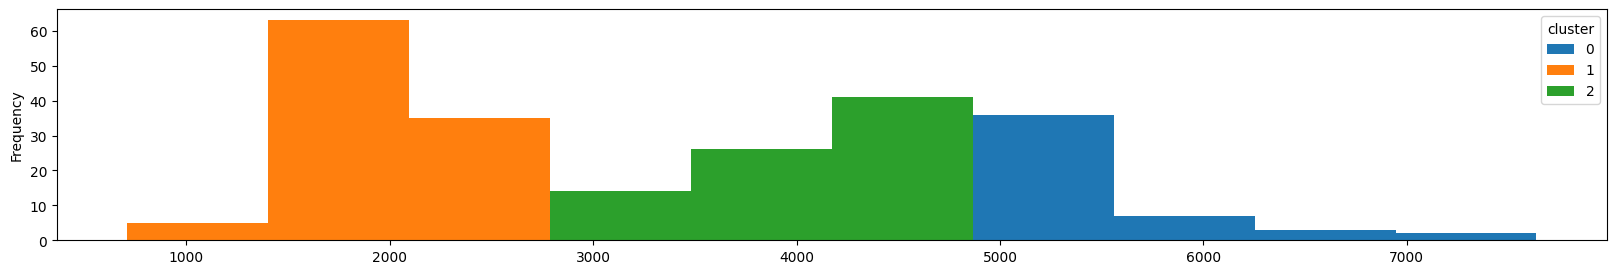

In [25]:
predictor2.pivot(columns='cluster', values="Precio/m2").plot.hist();

Para nuestra sorpresa, el Kmeans ha segmentado exactamente de la misma manera los datos. Esto nos reconforta ya que respalda nuestra toma de decisiones a la hora de segmentar las casas entre baratas, medias y caras.

In [26]:
#Cambio de labels de la variable cluster para que esten en orden
predictor2["clusterQ"] = predictor2["cluster"].replace({1:0, 2:1, 0:2})

Ejecutamos de nuevo los modelos de forma reafirmativa ya que si la segmentacion de clases ha sido la misma, deberiamos esperar los mismos resultados para los modelos de clasificación.

Para el modelo Bayesiano Ingenuo matriz de confusion es:


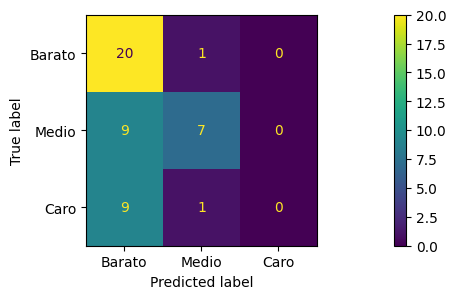

Con un accuracy de train de: 75.0 %
Con un accuracy de test de: 57.45 %
Con una fiabilidad de: 76.6 % 

Para el modelo SVC matriz de confusion es:


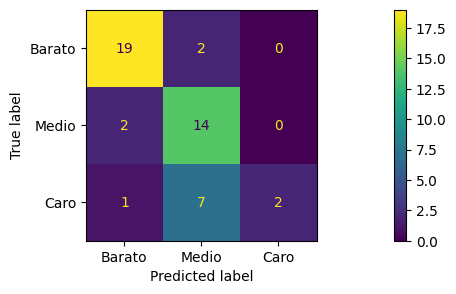

Con un accuracy de train de: 96.81 %
Con un accuracy de test de: 74.47 %
Con una fiabilidad de: 76.92 % 

Para el modelo XGBoost matriz de confusion es:


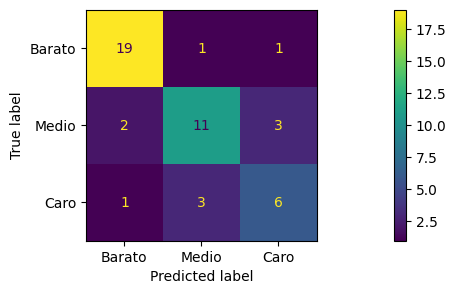

Con un accuracy de train de: 98.94 %
Con un accuracy de test de: 76.6 %
Con una fiabilidad de: 77.42 % 



In [27]:
run_models(texto_tfidf2, predictor2["clusterQ"], modellist)

A pesar de ver ligeras diferencias en los modelos, esto se puede atribuir a la separacion aleatoria entre train y test.